
# MY DR NOW – Medication Adherence Assessment  
**Final Submission** · June 27, 2025

MY DR NOW Data Analyst Intern Assessment:
- Data quality audit
- Data cleaning & validation
- Provider & clinic benchmarking
- Workflow timing analysis
- Dashboard visualizations
- Composite adherence score
- Exports of cleaned datasets & metrics
- Inline validation tests  
Run **Kernel → Restart & Run All** to generate all outputs and CSVs for GitHub.


## 1. Imports & Configuration

In [40]:
import pandas as pd
import numpy as np
import plotly.express as px
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_columns', None)
DATA_DIR = Path('.')  # Adjust if CSVs live elsewhere


## 2. Load Raw Data

In [41]:
pharmacy_raw   = pd.read_csv(DATA_DIR / 'pharmacy_refills 2.csv')
encounters_raw = pd.read_csv(DATA_DIR / 'provider_encounters 1.csv')
med_ref_raw    = pd.read_csv(DATA_DIR / 'medication_category_reference 1.csv')

print("Raw shapes:",
      "pharmacy", pharmacy_raw.shape,
      "encounters", encounters_raw.shape,
      "med_ref", med_ref_raw.shape)


Raw shapes: pharmacy (2578, 7) encounters (8559, 5) med_ref (2899, 2)


## 3. Data-Quality Audit

In [42]:
def audit(df, name):
    print(f"--- {name} ---")
    print("Shape:", df.shape)
    print("Missing %:", (df.isnull().mean()*100).round(2).to_dict())
    print("Dtypes:", df.dtypes.to_dict())
    print()

# Standardize columns
for df in [pharmacy_raw, encounters_raw, med_ref_raw]:
    df.columns = df.columns.str.lower().str.strip()

audit(pharmacy_raw, 'Pharmacy Refills Raw')
audit(encounters_raw, 'Provider Encounters Raw')
audit(med_ref_raw, 'Medication Reference Raw')


--- Pharmacy Refills Raw ---
Shape: (2578, 7)
Missing %: {'patient_id': 0.0, 'insurance_carrier': 0.0, 'drug_name': 0.0, 'quantity': 0.0, 'date_of_last_refill': 0.0, 'next_refill_date': 0.0, 'absolute_fail_date': 3.8}
Dtypes: {'patient_id': dtype('O'), 'insurance_carrier': dtype('O'), 'drug_name': dtype('O'), 'quantity': dtype('int64'), 'date_of_last_refill': dtype('O'), 'next_refill_date': dtype('O'), 'absolute_fail_date': dtype('O')}

--- Provider Encounters Raw ---
Shape: (8559, 5)
Missing %: {'patient_id': 0.0, 'contact_date': 0.0, 'provider_id': 0.0, 'clinic_id': 0.0, 'encounter_type': 0.0}
Dtypes: {'patient_id': dtype('O'), 'contact_date': dtype('O'), 'provider_id': dtype('int64'), 'clinic_id': dtype('int64'), 'encounter_type': dtype('O')}

--- Medication Reference Raw ---
Shape: (2899, 2)
Missing %: {'medication_name': 0.0, 'rx_category': 0.0}
Dtypes: {'medication_name': dtype('O'), 'rx_category': dtype('O')}



## 4. Cleaning & Validation

In [43]:
#Cleaning & Validation
def strip_whitespace(df):
    obj_cols = df.select_dtypes(include='object').columns
    df[obj_cols] = df[obj_cols].apply(lambda col: col.str.strip())
    return df

def validate_ids(df):
    df['patient_id'] = df['patient_id'].astype(str).str.strip()
    mask = df['patient_id'].str.isdigit()
    print(f"Kept {mask.sum():,}/{len(df):,} rows with numeric patient_id")
    return df[mask].copy()

# Make working copies and standardize columns
pharmacy = strip_whitespace(pharmacy_raw.copy())
encounters = strip_whitespace(encounters_raw.copy())
med_ref = strip_whitespace(med_ref_raw.copy()).rename(columns={'medication_name':'drug_name'})

# Validating patient IDs (drop only non-numeric)
pharmacy = validate_ids(pharmacy)
encounters = validate_ids(encounters)

# Parsing dates
pharmacy[['date_of_last_refill','next_refill_date','absolute_fail_date']] = (
    pharmacy[['date_of_last_refill','next_refill_date','absolute_fail_date']]
    .apply(pd.to_datetime, errors='coerce')
)

# Impute missing Absolute Fail Dates → assume failure on the refill date
pharmacy['absolute_fail_date'] = pharmacy['absolute_fail_date'] \
    .fillna(pharmacy['next_refill_date'])

encounters['contact_date'] = pd.to_datetime(encounters['contact_date'], errors='coerce')

# Droping any rows missing critical fields and dedupe
pharmacy.dropna(subset=['drug_name','next_refill_date'], inplace=True)
pharmacy.drop_duplicates(subset=['patient_id','drug_name','next_refill_date','quantity'], inplace=True)

encounters.dropna(subset=['contact_date'], inplace=True)
encounters.drop_duplicates(subset=['patient_id','contact_date','provider_id','clinic_id'], inplace=True)

# Merging medication category
med_ref.drop_duplicates(subset=['drug_name'], inplace=True)
pharmacy = pharmacy.merge(med_ref, on='drug_name', how='left')

# Any drug not found in med_ref gets “UNKNOWN”
pharmacy['rx_category'] = pharmacy['rx_category'].fillna('UNKNOWN')

# Deriving adherence flags and days_supply
pharmacy['on_time_refill'] = pharmacy['next_refill_date'] <= pharmacy['absolute_fail_date']
pharmacy['days_supply'] = (pharmacy['next_refill_date'] - pharmacy['date_of_last_refill']).dt.days
pharmacy.loc[pharmacy['days_supply'] < 0, 'days_supply'] = np.nan

# Final shapes
print("Clean shapes:", pharmacy.shape, encounters.shape, med_ref.shape)

# QA for imputation & categories
print("Null fail–dates:", pharmacy['absolute_fail_date'].isna().sum())           # should be 0
print("Null categories:", pharmacy['rx_category'].isna().sum())                 # should be 0
print("UNKNOWN categories:", (pharmacy['rx_category']=='UNKNOWN').sum())


Kept 2,244/2,578 rows with numeric patient_id
Kept 7,691/8,559 rows with numeric patient_id
Clean shapes: (2244, 10) (3935, 5) (249, 2)
Null fail–dates: 0
Null categories: 0
UNKNOWN categories: 0


## 5. Export Cleaned Data

In [44]:
pharmacy.to_csv(DATA_DIR/'cleaned_pharmacy.csv', index=False)
encounters.to_csv(DATA_DIR/'cleaned_encounters.csv', index=False)
med_ref.to_csv(DATA_DIR/'cleaned_med_ref.csv', index=False)
print("Cleaned CSVs exported")

# at the end of your “Exporting cleaned datasets” cell

# writing out the merged pharmacy + encounter info so we can consume it in Power BI
out_pharm = DATA_DIR / 'cleaned_pharmacy.csv'
pharmacy.to_csv(out_pharm, index=False)

print('→ Cleaned pharmacy with encounters written to', out_pharm.name)

Cleaned CSVs exported
→ Cleaned pharmacy with encounters written to cleaned_pharmacy.csv


## 6. Map Last Encounter to Refill

In [45]:
pharmacy.sort_values(['next_refill_date','patient_id'], inplace=True)
encounters.sort_values(['contact_date','patient_id'], inplace=True)

merged = pd.merge_asof(
    pharmacy, encounters,
    by='patient_id',
    left_on='next_refill_date',
    right_on='contact_date',
    direction='backward'
)

# Mark which refills actually had a prior encounter
merged['had_encounter'] = merged['contact_date'].notna()

merged['encounter_gap'] = (merged['next_refill_date'] - merged['contact_date']).dt.days

print(f"Encounter gap missing: {merged['encounter_gap'].isna().mean()*100:.1f}%")

Encounter gap missing: 18.3%


## 7. Provider & Clinic Benchmarking

In [46]:
encountered = merged.dropna(subset=['provider_id'])
provider_metrics = (
    encountered.groupby('provider_id')
    .agg(total_refills=('on_time_refill','size'),
         on_time=('on_time_refill','sum'),
         avg_gap=('encounter_gap','mean'))
    .assign(adherence_rate=lambda d: d['on_time']/d['total_refills'])
    .reset_index()
)
provider_metrics.to_csv(DATA_DIR/'provider_metrics.csv', index=False)
provider_metrics.head(3)

,provider_id,total_refills,on_time,avg_gap,adherence_rate
0,143.0,8,8,91.250000,1.000000
1,147.0,11,11,68.454545,1.000000
2,148.0,58,54,77.568966,0.931034


In [47]:
clinic_metrics = (
    encountered.groupby('clinic_id')
    .agg(total_refills=('on_time_refill','size'),
         on_time=('on_time_refill','sum'),
         avg_gap=('encounter_gap','mean'))
    .assign(adherence_rate=lambda d: d['on_time']/d['total_refills'])
    .reset_index()
)
clinic_metrics.to_csv(DATA_DIR/'clinic_metrics.csv', index=False)
clinic_metrics.head(3)

,clinic_id,total_refills,on_time,avg_gap,adherence_rate
0,1005001.0,204,199,76.044118,0.975490
1,1005002.0,75,71,86.440000,0.946667
2,1005003.0,84,83,68.761905,0.988095


## 8. Workflow Timing Analysis

In [48]:
# Defining your bins and labels exactly as before
bins   = [-np.inf, 0, 7, 30, 60, 90, np.inf]
labels = ['<0','0-6','7-29','30-59','60-89','90+']

# Creating the gap_bin column
merged['gap_bin'] = pd.cut(
    merged['encounter_gap'],
    bins=bins,
    labels=labels,
    right=False
)

# Grouping **without** dropping any categories (observed=False)
gap_summary = (
    merged.groupby('gap_bin', observed=False)
    .agg(total   = ('on_time_refill','size'),
         on_time = ('on_time_refill','sum'))
    .reindex(labels)                              # ensure all bins appear in order
    .assign(adherence_rate=lambda df: df['on_time']/df['total'])
    .reset_index()
)

# Exporting as before
gap_summary.to_csv('gap_summary.csv', index=False)


## 9. Weekly Adherence Trendline

In [49]:
# 9. Weekly Adherence Trendline
pharmacy['week'] = pharmacy['next_refill_date'].dt.to_period('W').dt.start_time

weekly = (
    pharmacy.groupby('week')
            .agg(total=('on_time_refill','size'),
                 on_time=('on_time_refill','sum'))
            .assign(adherence_rate=lambda df: df['on_time']/df['total'])
            .reset_index()
)

# Only complete weeks & remove low-volume noise
last_full = weekly['week'].max() - pd.Timedelta(days=7)
weekly = weekly[(weekly['week'] <= last_full) & (weekly['total'] >= 5)]

# Plot
px.line(weekly, x='week', y='adherence_rate', title='Weekly Adherence (All Refills)')

# Export for GitHub / Power BI
weekly.to_csv(DATA_DIR/'weekly_adherence.csv', index=False)

## 10. Interactive Provider Scatter

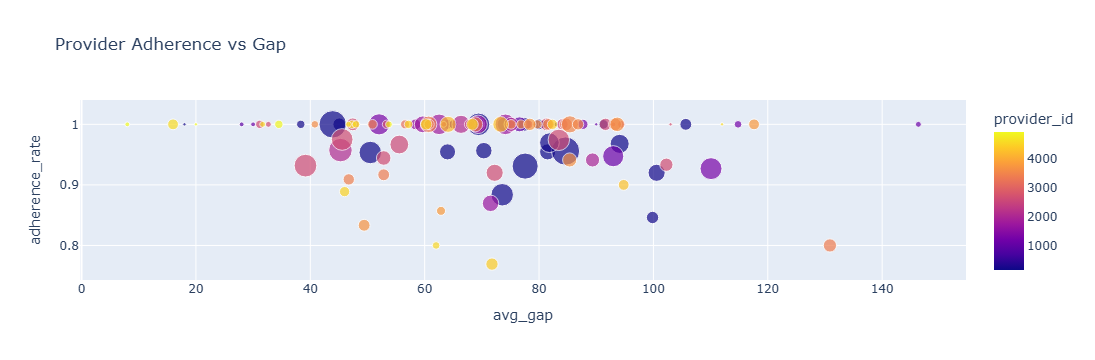

In [50]:
fig = px.scatter(
    provider_metrics, x='avg_gap', y='adherence_rate',
    size='total_refills', color='provider_id',
    hover_name='provider_id', title='Provider Adherence vs Gap'
)
fig.show()

## 11. Composite Adherence Score

In [51]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(provider_metrics[['adherence_rate','avg_gap','total_refills']])
scored = provider_metrics.copy()
scored[['ad_sc','gap_sc','vol_sc']] = scaled
scored['composite_score'] = 0.5*scored['ad_sc'] + 0.3*(1-scored['gap_sc']) + 0.2*scored['vol_sc']
scored.to_csv(DATA_DIR/'composite_scores.csv', index=False)
scored.sort_values('composite_score', ascending=False).head(3)

,provider_id,total_refills,on_time,avg_gap,adherence_rate,ad_sc,gap_sc,vol_sc,composite_score
7,162.0,64,64,43.921875,1.0,1.0,0.259676,0.940299,0.910157
37,1311.0,38,38,52.026316,1.0,1.0,0.318263,0.552239,0.814969
107,4605.0,10,10,16.000000,1.0,1.0,0.057831,0.134328,0.809516


## 12. Validation Tests

In [52]:
assert not merged.duplicated(['patient_id','drug_name','next_refill_date','quantity']).any()
assert provider_metrics['total_refills'].sum() == len(encountered)
print("All validation tests passed")

All validation tests passed
